In [17]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

tf.random.set_seed(42)
np.random.seed(42)

# 1. Build networks

In [2]:
def build_model(input_layers=1, verbose=False):

    inputs = layers.Input((36, 36, input_layers))

    conv1 = layers.Conv2D(32, (4, 4), activation='relu')(inputs)
    conv1 = layers.Conv2D(12, (4, 4), activation='relu')(conv1)
    
    conv2 = layers.Conv2D(16, (3, 3), activation='relu')(conv1)
    conv2 = layers.Conv2D(10, (3, 3), activation='relu')(conv2)
    conv2 = layers.Conv2D(8, (3, 3), activation='relu')(conv2)
    
    merge = layers.concatenate([
        layers.ZeroPadding2D((1, 1))(conv1),
        layers.ZeroPadding2D((4, 4))(conv2)
    ], axis=3)
    
    conv3 = layers.Conv2D(16, (5, 5), activation='relu')(merge)
    conv3 = layers.Conv2D(32, (5, 5), activation='relu')(conv3)
    conv3 = layers.Conv2D(1, (3, 3), activation='sigmoid')(conv3)
    
    model = models.Model(inputs, conv3)

    model.compile(
        optimizer=optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['mae']
    )

    if verbose:
        model.summary()
    
    return model


def build_future_model():
    return build_model(input_layers=2)

# 2. Prepare the data

In [3]:
def prepare_features(X, pad_coef=7):
    '''
    Переводит состояние автомата в формат, допустимый для архитектуры сети
    '''
    X = X.reshape((len(X), 22, 22, 1))
    X = np.pad(
        X, 
        ((0, 0), (pad_coef, pad_coef), (pad_coef, pad_coef), (0, 0)), 
        mode='wrap'
    )
    
    return X

## Load and split per steps data for the training

In [4]:
data = pd.read_csv("data/gtrain.csv")

train_data = []
for step in range(1, 6):    
    
    part_data = data[data['steps'] == step]
    part_data = part_data.drop(['id', 'steps'], axis='columns')
    
    X, y = part_data.iloc[:, :22*22], part_data.iloc[:, 22*22:]
    X = prepare_features(X.to_numpy())
    y = y.to_numpy().reshape((len(y), 22, 22, 1))

    train_data.append((X, y))

## Load and split features for the prediction

In [5]:
features = pd.read_csv("data/gtest.csv")

test_data = []
indices = []
for step in range(1, 6):    

    part_data = features[features['steps'] == step]
    part_indices = part_data['id'].to_numpy().reshape((part_data.shape[0], 1))
    part_data = part_data.drop(['id', 'steps'], axis='columns')
    
    X = prepare_features(part_data.to_numpy())
    
    test_data.append(X)
    indices.append(part_indices)

## Transform predictions and calculate metrics

Для более точной работы модели стоило бы настроить гиперпараметры (например, порог бинаризации: он наверняка существенно варьируется для каждой эпохи.

In [6]:
def extend_features(features, predictions):
    '''
    Склеивает состояние поля на шаге k с предсказанным состоянием k+1
    '''
    predicted_step = prepare_features(predictions)
    shape = features.shape
    return np.stack([features, predicted_step], axis=3).reshape((*shape[:-1], shape[-1]+1))

In [7]:
def merge_predictions(indices, predictions, threshold=0.5):
    '''
    Соединяет предсказанные позиции с их индексами при заданном пороге бинаризации в виде:
    [
        (index, flatten(prediction)),
        ...
    ]
    '''
    predictions = (predictions >= threshold)
    return np.hstack([indices, predictions.reshape((predictions.shape[0], 22*22))])

In [8]:
def calc_mae(predictions, answers, threshold=0.5):
    '''
    Вычисляет mean absolute error с заданным порогом бинаризации
    '''
    predictions = predictions >= threshold
    return np.mean(np.abs(predictions-answers))

# 3. Train and predict each model

## Accuracy and Loss plots

In [9]:
import matplotlib.pyplot as plt

def show_mae(history, split_num=0):
    plt.figure()
    
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs[split_num:], acc[split_num:], 'r', label='MAE')
    plt.plot(epochs[split_num:], val_acc[split_num:], 'b', label='Validation MAE')

    plt.xlabel('Epochs')
    plt.ylabel('MAE')

    plt.legend()
    plt.plot()


def show_loss(history, split_num=0):
    plt.figure()
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = list(range(1, len(loss) + 1))

    plt.plot(epochs[split_num:], loss[split_num:], 'r', label='Loss')
    plt.plot(epochs[split_num:], val_loss[split_num:], 'b', label='Validation loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.plot()

## Train-val splits

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
def test_model(model, X, y, epochs=30):
    
    model = models.clone_model(model)
    model.compile(
        optimizer=optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['mae']
    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=64,
        validation_data=(X_test, y_test)
    )
    
    show_mae(history)
    show_loss(history)
    
    print(calc_mae(model.predict(X_test), y_test))

## Predictions for the test data

In [12]:
TEST_ANSWERS = []

## First (base) model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 36, 36, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 33, 33, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 12)   6156        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 16)   1744        conv2d_1[0][0]                   
______________________________________________________________________________________________

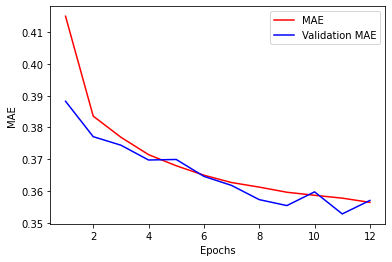

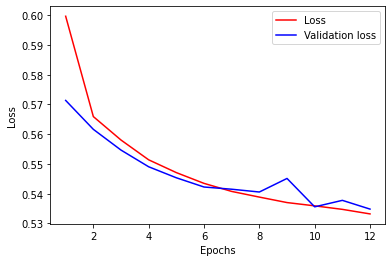

In [13]:
epochs_per_model = [12, 12, 9, 9, 9]

base_model = build_model(verbose=True)        
test_model(build_model(), *train_data[0], epochs=epochs_per_model[0])

X, y = train_data[0]
base_model.fit(
    X, y,
    batch_size=512,
    epochs=epochs_per_model[0]
)

TEST_ANSWERS.extend(merge_predictions(indices[0], base_model.predict(test_data[0])))

## Other models

In [14]:
def generate_features(models_list, step, features):
    
    # принимает предудыщее поколение автомата (step (от 0 до 3 включительно)), 
    # по нему возвращает предсказание в один шаг
    
    if step > 0:
        return extend_features(
            features,
            models_list[step].predict(generate_features(models_list, step-1, features))
        )
    else:
        return extend_features(features, models_list[0].predict(features))

In [18]:
models_list = [base_model]
for step in range(1, 5):
    
    model = build_future_model()
    X, y = train_data[step]
    X = generate_features(models_list, step-1, X)
    
#     test_model(model, X, y, epochs_per_model[step])
    
    model.fit(
        X, y,
        batch_size=64,
        epochs=epochs_per_model[step]
    )
        
    predictions = model.predict(generate_features(models_list, step-1, test_data[step]))
    TEST_ANSWERS.extend(merge_predictions(indices[step], predictions))
               
    models_list.append(model)

Epoch 1/12
157/157 [==============================] - 15s 96ms/step - loss: 0.6587 - mae: 0.4666
Epoch 2/12
157/157 [==============================] - 15s 96ms/step - loss: 0.6393 - mae: 0.4486
Epoch 3/12
157/157 [==============================] - 15s 98ms/step - loss: 0.6355 - mae: 0.4449
Epoch 4/12
157/157 [==============================] - 15s 96ms/step - loss: 0.6335 - mae: 0.4430
Epoch 5/12
157/157 [==============================] - 15s 97ms/step - loss: 0.6324 - mae: 0.4420
Epoch 6/12
157/157 [==============================] - 15s 97ms/step - loss: 0.6312 - mae: 0.4408
Epoch 7/12
157/157 [==============================] - 15s 96ms/step - loss: 0.6306 - mae: 0.4403
Epoch 8/12
157/157 [==============================] - 15s 98ms/step - loss: 0.6301 - mae: 0.4400
Epoch 9/12
157/157 [==============================] - 15s 97ms/step - loss: 0.6291 - mae: 0.4390
Epoch 10/12
157/157 [==============================] - 16s 99ms/step - loss: 0.6290 - mae: 0.4387
Epoch 11/12
157/157 [========

# 4. Save answers

In [19]:
TEST_ANSWERS.sort(key=lambda x: x[0])


columns = ['id'] + ['y_' + str(i) for i in range(0, 22 * 22)]
answers = pd.DataFrame(
    data=np.vstack(TEST_ANSWERS),
    columns=columns
)

answers.to_csv('submission.csv', index=None)
answers.head()

,id,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,...,y_474,y_475,y_476,y_477,y_478,y_479,y_480,y_481,y_482,y_483
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,3,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
